<a href="https://colab.research.google.com/github/Erike-Simon/CESAR-AED/blob/main/TempSeries_aula5_acidentes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Aplicando em série temporal de acidentes de trânsito

In [ ]:
pip install yfinance pydataset pmdarima tqdm prophet

In [ ]:
import yfinance as yf
from pydataset import data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima import KPSSTest, auto_arima
from tqdm import tqdm

from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor
from prophet import Prophet


In [ ]:
df_ac = pd.read_csv('./acidents.csv')
df_ac.columns = ['ds', 'y', 'feriado', 'day']

In [ ]:
df_ac.head()

,ds,y,feriado,day
0,2015-06-01,39,0,0
1,2015-06-02,49,0,1
2,2015-06-03,46,0,2
3,2015-06-04,28,1,3
4,2015-06-05,40,0,4


In [ ]:
# Dividindo os dados
test_size = 90
ts_train = df_ac.iloc[0:-test_size]
ts_test = df_ac.iloc[-test_size:]

Criando e ajustando o modelo PROPHET

In [ ]:
m = Prophet(seasonality_mode='additive') # cria o modelo prophet
m.add_seasonality(name='weekly', period = 7, fourier_order=3)
# Adiciona um regressor chamado 'feriado'. Isso permite que você incorpore informações sobre feriados no modelo.
# Se você tiver um DataFrame com colunas 'ds' (datas) e 'feriado', o Prophet usará essas informações ao ajustar o modelo.
m.add_regressor('feriado')
# Adiciona um regressor chamado 'day'. Da mesma forma, isso
# permite que você inclua informações adicionais sobre o dia no modelo.
m.add_regressor('day')
#  Ajusta o modelo aos dados de treinamento
m.fit(ts_train)

INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbsk91b26/z4dtx3bs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbsk91b26/bgewhqt9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7897', 'data', 'file=/tmp/tmpbsk91b26/z4dtx3bs.json', 'init=/tmp/tmpbsk91b26/bgewhqt9.json', 'output', 'file=/tmp/tmpbsk91b26/prophet_modelgxnvzcjm/prophet_model-20231111002126.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:21:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:21:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
prevs_direct = m.predict(ts_test.drop(columns='y'))

In [ ]:
prevs_direct['real']= ts_test['y'].values

Plot dos resultados do modelo PROPHET

<Axes: >

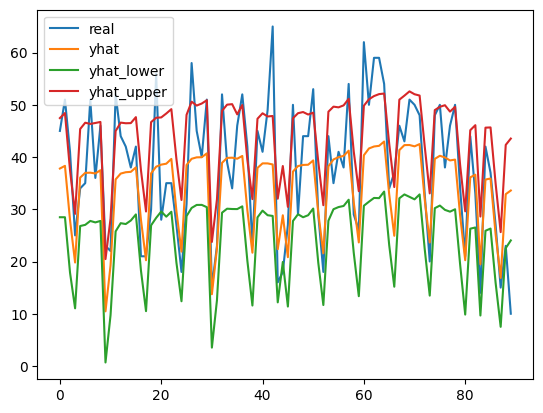

In [ ]:
# 'yhat_lower' é uma estimativa inferior para o intervalo de confiança das previsões.
# 'yhat_upper' é uma estimativa superior para o intervalo de confiança das previsões.
prevs_direct[['real', 'yhat', 'yhat_lower',	'yhat_upper']].plot()

In [ ]:
ts_train.head()

,ds,y,feriado,day
0,2015-06-01,39,0,0
1,2015-06-02,49,0,1
2,2015-06-03,46,0,2
3,2015-06-04,28,1,3
4,2015-06-05,40,0,4


Criando e ajustando o modelo ARIMA (com variável exógena 'feriado')







In [ ]:
model = auto_arima(ts_train['y'].values, X=ts_train[['feriado', 'day']].values,
            start_p=2, start_q=2, max_p=5, max_d=2,
            max_q=5, start_P=1, start_Q=1, max_P=2,
            max_D=1, max_Q=2, max_order=10, m=7,
            stepwise=True, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[7] intercept   : AIC=inf, Time=13.95 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=11473.483, Time=0.79 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=11269.182, Time=9.11 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=11301.225, Time=6.42 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=14523.626, Time=0.49 sec
 ARIMA(1,0,0)(0,0,0)[7] intercept   : AIC=11364.683, Time=1.63 sec
 ARIMA(1,0,0)(2,0,0)[7] intercept   : AIC=11216.966, Time=14.50 sec
 ARIMA(1,0,0)(2,0,1)[7] intercept   : AIC=11174.599, Time=17.16 sec
 ARIMA(1,0,0)(1,0,1)[7] intercept   : AIC=inf, Time=7.58 sec
 ARIMA(1,0,0)(2,0,2)[7] intercept   : AIC=inf, Time=18.02 sec
 ARIMA(1,0,0)(1,0,2)[7] intercept   : AIC=inf, Time=14.54 sec
 ARIMA(0,0,0)(2,0,1)[7] intercept   : AIC=11196.830, Time=15.64 sec
 ARIMA(2,0,0)(2,0,1)[7] intercept   : AIC=11323.013, Time=23.55 sec
 ARIMA(1,0,1)(2,0,1)[7] intercept   : AIC=inf, Time=18.10 sec
 ARIMA(0,0,1)(2,0,1)[7] intercept   : AIC

In [ ]:
# previvões do modelo ARIMA
prevs_arima_direct = model.predict(test_size,
                                   ts_test[['feriado', 'day']].values )

In [ ]:
prevs_h_steps = []

for t in tqdm(ts_test[['y', 'feriado', 'day']].to_dict('records')):
  prevs_h_steps.append(model.predict(1, [[t['feriado'], t['day']]] )[0])
  model.update(t['y'], X=[[ t['feriado'], t['day'] ]])


100%|██████████| 90/90 [03:34<00:00,  2.39s/it]


In [ ]:
prevs_direct['arima_direct'] = prevs_arima_direct
prevs_direct['arima_1step'] = prevs_h_steps

Plot dos resultados do modelo ARIMA

<Axes: >

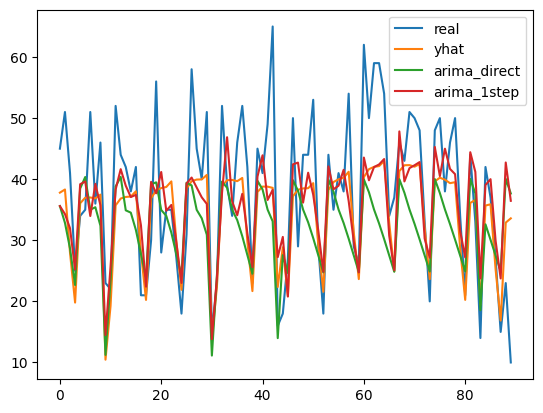

In [ ]:
prevs_direct[['real', 'yhat', 'arima_direct', 'arima_1step']].plot()

Métricas de desempenho

In [ ]:
def mean_square_error(y_true, y_pred):
    y_true = np.asmatrix(y_true).reshape(-1)
    y_pred = np.asmatrix(y_pred).reshape(-1)

    return np.square(np.subtract(y_true, y_pred)).mean()

def root_mean_square_error(y_true, y_pred):

    return mean_square_error(y_true, y_pred)**0.5


def mean_absolute_percentage_error(y_true, y_pred):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)

    if len(np.where(y_true == 0)[0]) > 0:
        return np.inf
    else:
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


def mean_absolute_error(y_true, y_pred):

    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)

    return np.mean(np.abs(y_true - y_pred))


def u_theil(y_true, y_pred):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)

    error_sup = np.square(np.subtract(y_true, y_pred)).sum()
    error_inf = np.square(np.subtract(y_pred[0:(len(y_pred) - 1)], y_pred[1:(len(y_pred))])).sum()

    return error_sup / error_inf


def average_relative_variance(y_true, y_pred):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)
    mean = np.mean(y_true)

    error_sup = np.square(np.subtract(y_true, y_pred)).sum()
    error_inf = np.square(np.subtract(y_pred, mean)).sum()

    return error_sup / error_inf


def prediction_of_change_in_direction(y_true, y_pred):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)

    true_sub = np.subtract(y_true[0:(len(y_true) - 1)], y_true[1:(len(y_true))])
    pred_sub = np.subtract(y_pred[0:(len(y_pred) - 1)], y_pred[1:(len(y_pred))])

    mult = true_sub * pred_sub
    result = 0
    for m in mult:
        if m > 0:
            result = result + 1

    return (100 * (result / len(y_true)))


def gerenerate_metric_results(y_true, y_pred):
    return {'MSE': mean_square_error(y_true, y_pred),
            'RMSE':root_mean_square_error(y_true, y_pred),
            'MAPE': mean_absolute_percentage_error(y_true, y_pred),
            'MAE': mean_absolute_error(y_true, y_pred),
            'theil': u_theil(y_true, y_pred),
            'ARV': average_relative_variance(y_true, y_pred),
            'POCID': prediction_of_change_in_direction(y_true, y_pred)}

In [ ]:
metric_results = []
for model_name in ['yhat', 'arima_direct', 'arima_1step']:
  y_true = prevs_direct['real']
  y_pred = prevs_direct[model_name]
  dict_result = gerenerate_metric_results(y_true, y_pred)
  dict_result['model_name'] = model_name
  metric_results.append(dict_result)

pd.DataFrame(metric_results)

,MSE,RMSE,MAPE,MAE,theil,ARV,POCID,model_name
0,82.175330,9.065061,20.253013,7.135098,0.955546,1.088741,65.555556,yhat
1,142.755858,11.948048,26.110821,9.482300,2.197494,1.822840,66.666667,arima_direct
2,96.964139,9.847037,23.773807,7.830985,1.129774,1.676345,62.222222,arima_1step


O modelo PROPHET performou melhor do que o modelo ARIMA, apesar de algumas métricas serem ruins.